H,W:  512 512


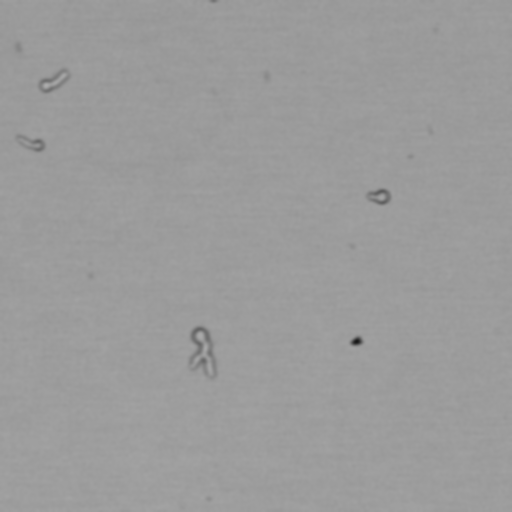

Reszied
Size:  (64, 64, 3)


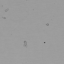

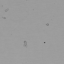

[INFO] looping over pyramid/windows took 0.10447 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 0.51260 seconds
Size of LabelBoxProb  PacC
after scanning


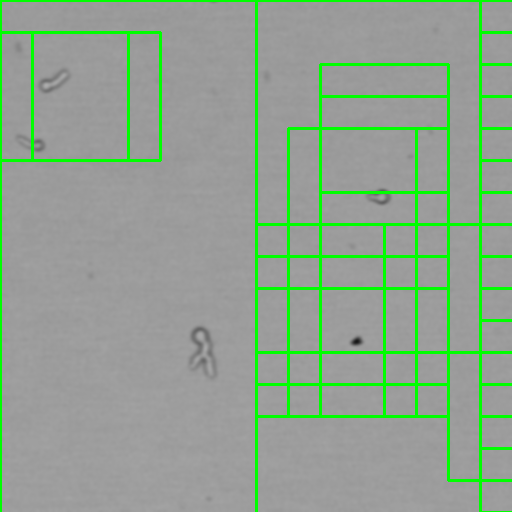

After


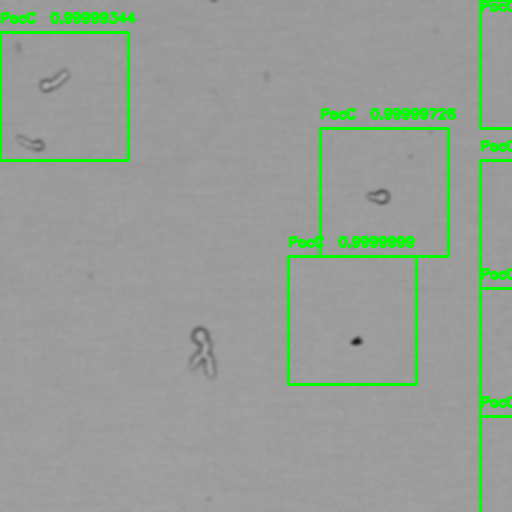

Done!
Spore Count  7


In [8]:
import pandas as pd 
import os
import numpy as np 
import cv2 
import tensorflow as tf 
from tensorflow.keras import utils
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from keras.preprocessing import image 
from tensorflow import shape
#from imutils.object_detection import non_max_suppression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from skimage.segmentation import mark_boundaries
from google.colab.patches import cv2_imshow # I used this becuase imshow from cv2 cause colab to crash ¯\_(ツ)_/¯
import imutils
import time

'''
accuracy of my detections is dependent 
on image pyramid scale, 
sliding window step, and ROI size
'''

def pyramid(image, scale=1.5, minSize=(256, 256)): # Default minsize used to limit prymid otherwise it could be infitley small
    # yield the original image
    yield image
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
    print("Reszied")
    print("Size: ",image.shape)
    cv2_imshow(image)
    yield image

def sliding_window(image, stepSize, windowSize = (100,100)):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# load the image and Classifer model and define the window width and height
model_path = "/content/drive/MyDrive/VGG16_1" #61% accuracy
model = tf.keras.models.load_model(model_path) 
WIDTH = 512 # will use this to resize all camera images and test data images to one size
Orgimage = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Tests/99.png")
Orgimage = imutils.resize(Orgimage, width=WIDTH)
Orgimage = cv.GaussianBlur(Orgimage,(7,7),0)

minS = (128,128)
ROI_size = minS #  the size of the window which is the size of the ROI

minConf = 0.99999 # My minimum probability threshold
pry_scale = 2
win_step = 32 # step size for window need to balance between time and accuracy 

INPUT_SIZE = (128,128)
(H, W) = Orgimage.shape[:2]
print ('H,W: ', H,W)

pyramidImg = pyramid(Orgimage, scale=pry_scale, minSize=minS)
rois = [] # Holds the regions of interest (ROIs) generated from pyramid + sliding window output
locs = [] #  Stores the (x, y)-coordinates of where the ROI was in the original image
start = time.time()
# loop over the image pyramid
#First get the scale factor for image, than loop sliding window on the image

for image in pyramidImg:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    cv2_imshow(image)
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, win_step, ROI_size):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_size[0] * scale)
        h = int(ROI_size[1] * scale)
        # take the ROI and preprocess it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        '''
        #Uncomment this section is to visulaise my ROI 
        clone = Orgimage.copy()
        cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the visualization and current ROI
        clone = Orgimage.copy()
        print("Visualization")
        cv2_imshow(clone)
        print("ROI")
        cv2_imshow(roiOrig)'''
        
        '''
        clone2 = image.copy()
        cv2.rectangle(clone2, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2_imshow(clone2)
        cv2.waitKey(1)
        time.sleep(0.025)
        cv2.waitKey(0)'''

end = time.time()
# end of Pyramid and sliding window

print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
#print("Prediction ",preds) 
labels  = {0: 'NsdC', 1: 'PacC', 2: 'RfeC', 3: 'WT'}
Category_index = preds.argmax(axis=-1) # Just need the top predcition of that ROI
maxProb = preds.max(axis=-1)
#print("Category_index ",Category_index) 
#print("Max probability ",maxProb)

LabelBoxProb1 = []
LabelBoxProb = []
boxes = []
boxes3 = []
probs =[]
probs3 =[]
names = []
names3 = []
counter = 0
#Filter out boxes with predcitons below threshold set in minConf
for (i, p) in enumerate(Category_index):
	# grab the prediction information for the current ROI
    prob = maxProb[i]
    label = Category_index[i]
    # filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
    if prob >= minConf :
        counter = counter + 1
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i] #.append((locs[i],labels.get(label)))
        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = [labels.get(label,[])]
        L.append(box)
        L.append(prob)
        LabelBoxProb.append(L)
        #labels[label] = L
print("Size of LabelBoxProb ",  LabelBoxProb[0][0])
# loop over the labels for each of detected objects in the image

clone = Orgimage.copy()
# loop over all bounding boxes for the current label
for (name, box, prob) in LabelBoxProb:
    # draw the bounding box on the image
    boxes.append(box)
    probs.append(prob)
    names.append(name) #<----------------- use this to rpelace label in box labelling
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

# show the results *before* applying non-maxima suppression, then
# clone the image again so we can display the results *after*
# applying non-maxima suppression
print("after scanning")
cv2_imshow(clone)
clone = Orgimage.copy()

boxes1 = np.array(boxes, dtype=np.int64)
probs1 = np.array(probs, dtype=np.float32)
boxes2= tf.image.non_max_suppression(boxes1, probs1, 100,
                          iou_threshold=0.01,
                          score_threshold=float('-inf'), 
                          name=None)
#boxes2 = non_max_suppression(boxes1, probs1)
c=0


for j in range(len(boxes2)):
  LabelBoxProb1.append(LabelBoxProb[boxes2[j]])
  
totalNumberOFSpores = len(LabelBoxProb1)

for (fungi,box3,prob3) in LabelBoxProb1:
  # draw the bounding box on the image
  (startX, startY, endX, endY) = box3
  cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(clone,str(fungi) +"  " +str(prob3), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
print("After")
cv2_imshow(clone)
cv2.waitKey(0)
'''
for (startX, startY, endX, endY) in boxes2:
    
    # draw the bounding box and label on the image
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(clone, labels.get(label,[])+" "+str(probs1[c]), (startX, y),
  cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    c=c+1'''
# show the output after apply non-maxima suppression


#Now to pply NOn Maximum suppersion
# extract the bounding boxes and associated prediction


# loop over all bounding boxes that were kept after applying
# non-maxima suppression

print("Done!")
print("Spore Count ", totalNumberOFSpores)